# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [ ]:
# ===============================
# 🔹 Core Python Libraries
# ===============================

import numpy as np  
# NumPy is used for numerical operations on arrays and matrices. 
# It's essential for efficient mathematical computations in machine learning pipelines.
# Example: Converting lists into arrays, handling feature vectors, etc.

import pandas as pd  
# Pandas is used for data manipulation and analysis.
# You’ll use it to load the Alexa review dataset (CSV file), clean it, and explore the data.
# Example: Reading 'amazon_alexa.tsv', checking missing values, or filtering reviews.


# ===============================
# 🔹 Data Visualization Libraries
# ===============================

import matplotlib.pyplot as plt  
# Matplotlib is used for creating static, high-quality visualizations like bar charts or histograms.
# In sentiment analysis, you might visualize review distribution or class balance.

import seaborn as sns  
# Seaborn is built on top of Matplotlib and provides a simpler syntax for attractive statistical plots.
# It will help visualize correlations, confusion matrices, or class counts more easily.


# ===============================
# 🔹 Natural Language Processing (NLP) Libraries
# ===============================

import nltk  
# NLTK (Natural Language Toolkit) is one of the most popular libraries for NLP.
# It provides tools for text preprocessing like tokenization, stemming, and stopword removal.

from nltk.stem.porter import PorterStemmer  
# PorterStemmer is an algorithm that reduces words to their root form (stemming).
# Example: "running", "runs", "ran" → "run"
# This helps reduce vocabulary size and improves model generalization.

nltk.download('stopwords')  
# Downloads a list of common words (stopwords) that carry little meaning, like “the”, “is”, “at”.
# These are usually removed to reduce noise in text data.

from nltk.corpus import stopwords  
STOPWORDS = set(stopwords.words('english'))  
# Loads the English stopword set and stores it in a Python set for faster lookup.
# You’ll remove these words from reviews before vectorizing the text.


# ===============================
# 🔹 Machine Learning Utilities
# ===============================

from sklearn.model_selection import train_test_split  
# Splits your dataset into training and testing sets.
# This ensures you can evaluate how well your model generalizes to unseen data.

from sklearn.preprocessing import MinMaxScaler  
# Normalizes numerical features to a fixed range (e.g., 0–1).
# Though text data often doesn’t need scaling, you may use it for other numeric features if present.

from sklearn.feature_extraction.text import CountVectorizer  
# Converts text data into numerical feature vectors using Bag-of-Words (BoW) representation.
# Each review becomes a vector counting the frequency of each word in your vocabulary.

from sklearn.model_selection import cross_val_score  
# Performs cross-validation — splits the data multiple times to ensure the model’s performance is stable.
# Helps prevent overfitting and provides a more reliable accuracy estimate.


# ===============================
# 🔹 Machine Learning Models
# ===============================

from sklearn.ensemble import RandomForestClassifier  
# A popular ensemble model that combines many decision trees to improve accuracy and prevent overfitting.
# It’s often used as a baseline for text classification tasks like sentiment analysis.

from sklearn.tree import DecisionTreeClassifier  
# A simpler, single decision-tree model.
# Often used for comparison or interpretability in classification problems.

from xgboost import XGBClassifier  
# An advanced, high-performance gradient boosting model.
# It’s efficient and usually provides strong results for text and tabular classification tasks.


# ===============================
# 🔹 Model Evaluation & Optimization
# ===============================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  
# confusion_matrix: Creates a table comparing predicted vs actual labels (e.g., positive/negative).
# ConfusionMatrixDisplay: Plots the matrix visually for clearer analysis of model performance.

from sklearn.model_selection import GridSearchCV  
# Performs hyperparameter tuning — systematically tests different parameter combinations.
# Helps you find the best settings for models like RandomForest or XGBoost.

from sklearn.model_selection import StratifiedKFold  
# A variation of K-Fold cross-validation that preserves class balance (useful in imbalanced datasets).
# Ensures that each fold has approximately the same proportion of positive/negative samples.

from sklearn.metrics import accuracy_score  
# Calculates the percentage of correct predictions out of total samples.
# One of the key metrics for evaluating sentiment classification performance.


# ===============================
# 🔹 (Optional) Word Cloud Visualization
# ===============================

# from wordcloud import WordCloud
# WordCloud is used to visualize the most frequent words in reviews.
# It gives a quick qualitative sense of what words dominate positive or negative sentiments.


# ===============================
# 🔹 Utility Libraries
# ===============================

import pickle  
# Used for saving (serializing) trained models to disk and loading them later.
# Example: Saving your trained RandomForest model to reuse without retraining.

import re  
# The regular expressions module, used for text cleaning.
# Example: Removing punctuation, HTML tags, or non-alphabetic characters from reviews before vectorization.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exploratory Data Analysis

In [ ]:
# ===============================
# 🔹 Loading the Alexa Reviews Dataset
# ===============================

data = pd.read_csv(
    r"C:\Users\Admin\Desktop\Programing\Projects\Sentiment Analysis\alexa-sentiment-analysis\amazon_alexa.tsv",  # file path to your dataset
    delimiter = '\t',   # '\t' specifies that this file is tab-separated (TSV file, not CSV)
    quoting = 3         # 3 = csv.QUOTE_NONE → disables quote handling (keeps text exactly as-is)
)


Dataset shape : (3150, 5)


In [107]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [108]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [109]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [ ]:
# ===============================
# 🔹 Checking for Missing Reviews in the Dataset
# ===============================

# This line filters and displays rows where the 'verified_reviews' column has missing (NaN) values.
# The goal is to identify if any reviews are empty or null, which could cause issues later in preprocessing.

data[data['verified_reviews'].isna() == True]
# data[...] → selects rows from the DataFrame that meet a condition.
# data['verified_reviews'] → accesses the 'verified_reviews' column containing text reviews.
# .isna() → returns True for each row where the value is missing (NaN) and False otherwise.
# == True → filters only the rows where the result of .isna() is True (i.e., missing reviews).
# Final output: displays all rows where 'verified_reviews' is missing, if any exist.


,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [ ]:
# ===============================
# 🔹 Dropping Missing Records from the Dataset
# ===============================

# This line removes any rows in the dataset that contain missing (NaN) values in any column.
# It ensures that only complete records remain for analysis, avoiding errors during preprocessing or model training.

data.dropna(inplace=True)
# data.dropna() → identifies all rows with at least one NaN (missing) value and removes them.
# inplace=True → applies the change directly to the existing DataFrame without creating a copy.
# After this operation, the dataset will no longer contain rows with null values.


In [112]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [ ]:
# ===============================
# 🔹 Creating a New Feature Column for Review Length
# ===============================

# This line creates a new column named 'length' in the dataset.
# It stores the number of characters present in each review from the 'verified_reviews' column.
# Measuring text length can be useful for exploratory data analysis or as an additional feature for sentiment prediction.

data['length'] = data['verified_reviews'].apply(len)
# data['verified_reviews'] → selects the column containing the text reviews.
# .apply(len) → applies the built-in Python len() function to each review string to calculate its length.
# data['length'] = ... → assigns the computed lengths as a new column in the DataFrame.
# Example: if a review is "Love Alexa", its length will be 10 (including the space).


In [114]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [115]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [116]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [117]:
len(data)

3149

In [118]:
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


Let's plot the above values in a bar graph

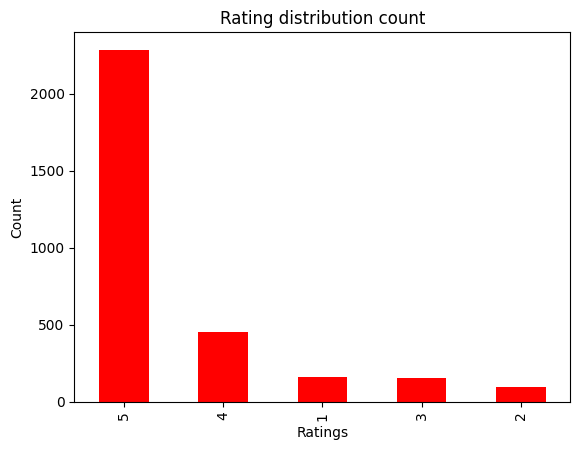

In [119]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [120]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


Let's plot the above values in a pie chart

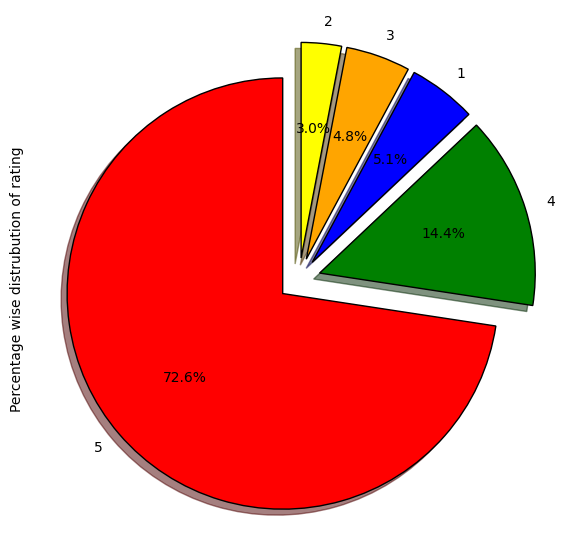

In [121]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [122]:
#Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [123]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [124]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

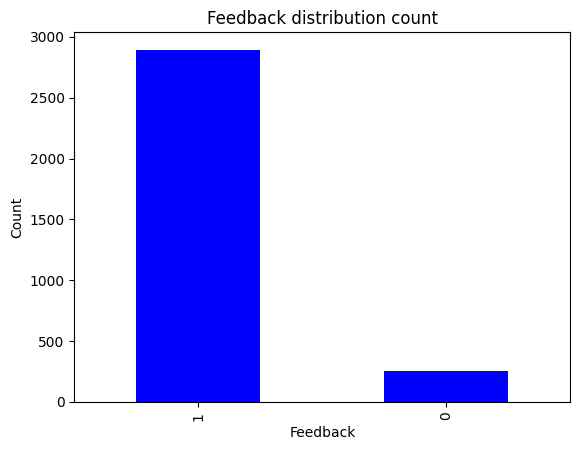

In [125]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [126]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

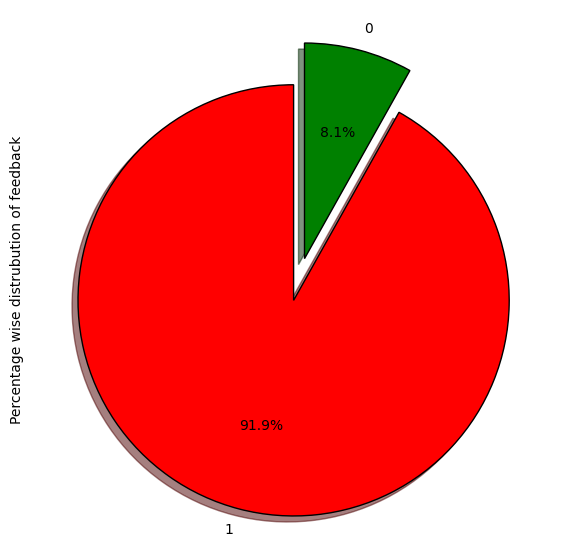

In [127]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [128]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [129]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [130]:
#Distinct values of 'variation' and its count

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


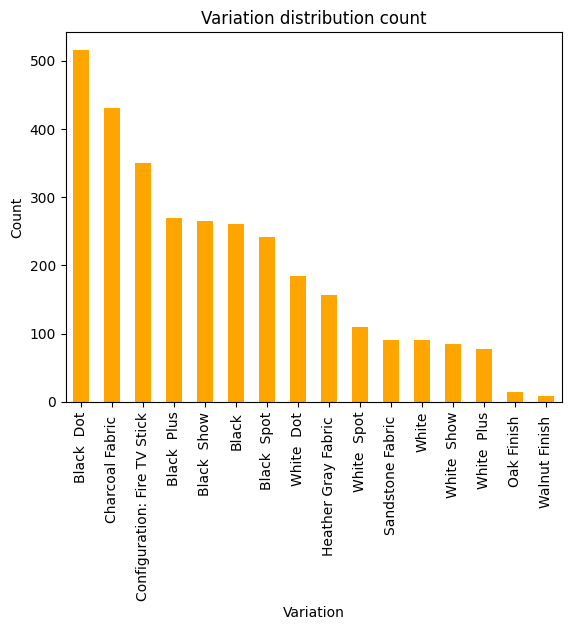

In [131]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [132]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


Mean rating according to variation

In [133]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Let's analyze the above ratings

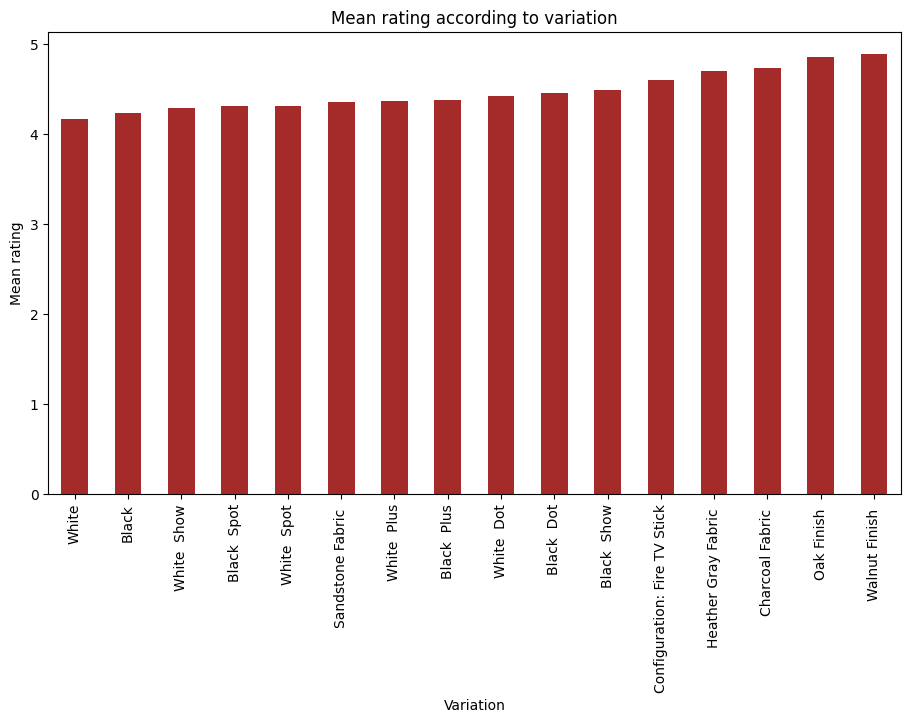

In [134]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [135]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

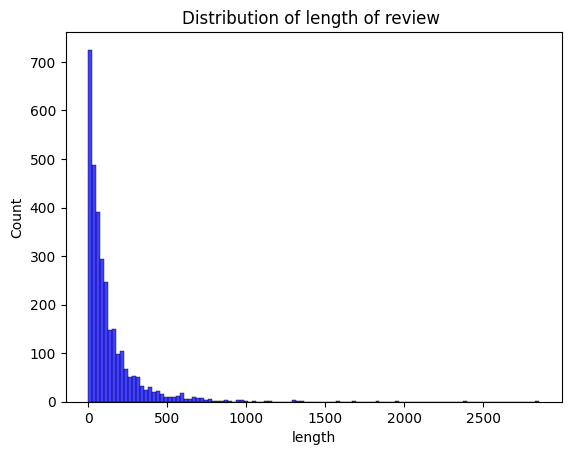

In [136]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

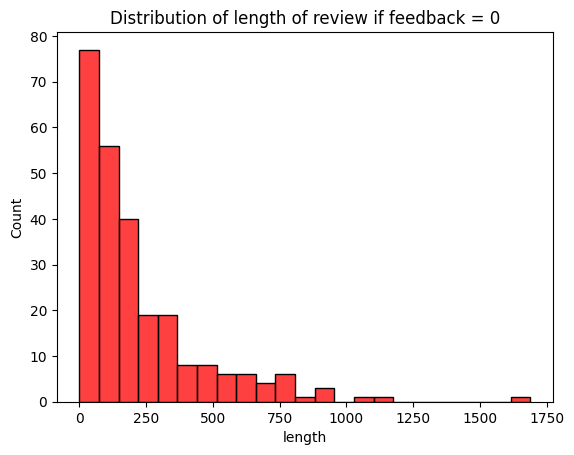

In [137]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

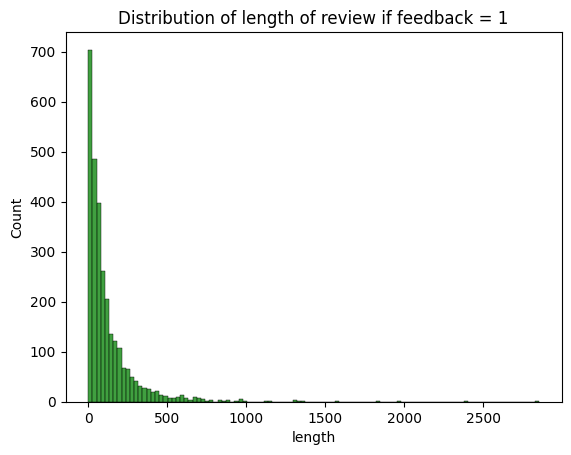

In [138]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

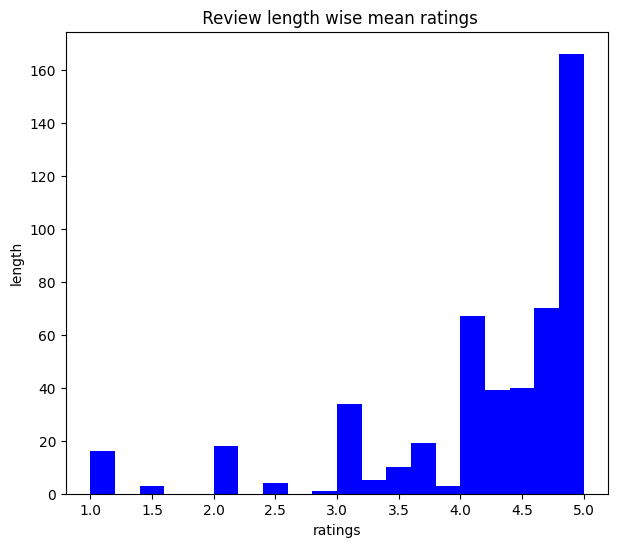

In [139]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [140]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

In [141]:
# # Combine all reviews
# reviews = " ".join([review for review in data['verified_reviews']])

# # Initialize wordcloud object
# wc = WordCloud(background_color='white', max_words=50)

# # Generate and plot wordcloud
# plt.figure(figsize=(10,10))
# plt.imshow(wc.generate(reviews))
# plt.title('Wordcloud for all reviews', fontsize=10)
# plt.axis('off')
# plt.show()

Lets find the unique words in each feedback category

In [142]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


In [143]:
# wc = WordCloud(background_color='white', max_words=50)

# # Generate and plot wordcloud
# plt.figure(figsize=(10,10))
# plt.imshow(wc.generate(unique_negative))
# plt.title('Wordcloud for negative reviews', fontsize=10)
# plt.axis('off')
# plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

In [144]:
# wc = WordCloud(background_color='white', max_words=50)

# # Generate and plot wordcloud
# plt.figure(figsize=(10,10))
# plt.imshow(wc.generate(unique_positive))
# plt.title('Wordcloud for positive reviews', fontsize=10)
# plt.axis('off')
# plt.show()

In [145]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [146]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                           # lowercase
    text = re.sub(r'[^a-z\s]', '', text)               # remove punctuation/numbers
    words = text.split()
    words = [ps.stem(w) for w in words if w not in stop_words]  # remove stopwords + stem
    return " ".join(words)


In [147]:
data['clean_text'] = data['verified_reviews'].apply(clean_text)

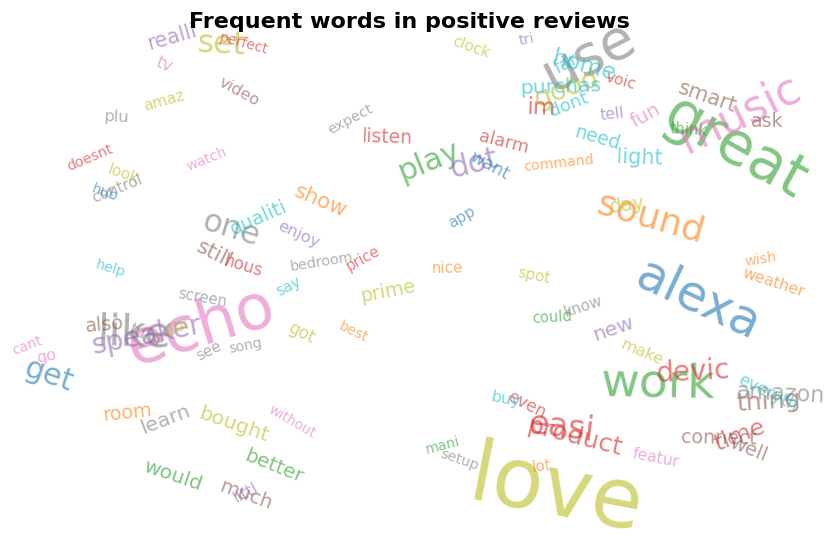

In [148]:
plot_word_bubbles(data[data['feedback'] == 1]['clean_text'],
                  n=100,
                  title="Frequent words in positive reviews")


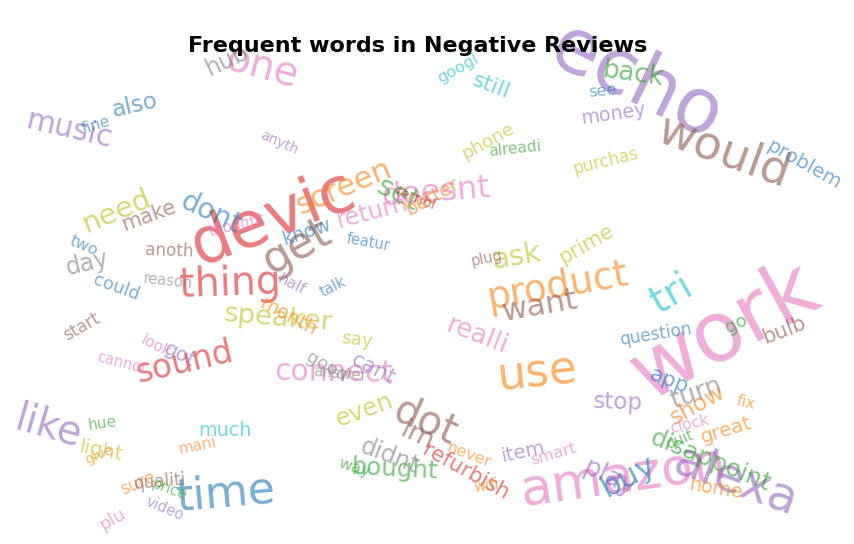

In [149]:
plot_word_bubbles(
    data[data['feedback'] == 0]['clean_text'],
    n=100,
    title="Frequent words in Negative Reviews"
)

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [150]:
from nltk.stem import PorterStemmer
import re

corpus = []
stemmer = PorterStemmer()
for i in range(data.shape[0]):
    text = str(data.iloc[i]['verified_reviews'])        # <- coerce to str
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [stemmer.stem(word) for word in words if word not in STOPWORDS]
    corpus.append(' '.join(words))


Using Count Vectorizer to create bag of words

In [151]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [152]:
#Saving the Count Vectorizer
pickle.dump(cv, open(r'C:\Users\Admin\Desktop\Programing\Projects\Sentiment Analysis\alexa-sentiment-analysis\countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [153]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing.

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [155]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


We'll scale X_train and X_test so that all values are between 0 and 1.

In [156]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [157]:
#Saving the scaler model
pickle.dump(scaler, open(r'C:\Users\Admin\Desktop\Programing\Projects\Sentiment Analysis\alexa-sentiment-analysis\scaler.pkl', 'wb'))

#### Random Forest

In [158]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [159]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9439153439153439


In [160]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [161]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

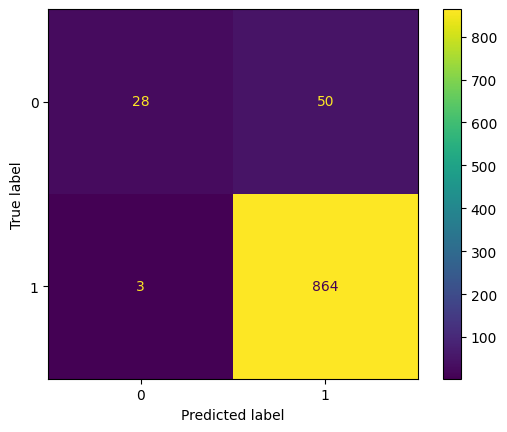

In [162]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [163]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9319477581242287
Standard Variance : 0.008805008902081033


Applying grid search to get the optimal parameters on random forest

In [164]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [165]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [True], 'max_depth': [80, 100], 'min_samples_split': [8, 12], 'n_estimators': [100, 300]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,100


In [166]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [167]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.73321234119783
Cross validation mean accuracy on test set : 92.16764972776768
Accuracy score for test set : 0.9439153439153439


#### XgBoost

In [168]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [169]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9718693284936479
Testing Accuracy : 0.9375661375661376


In [170]:
y_preds = model_xgb.predict(X_test)

In [171]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 35  43]
 [ 18 849]]


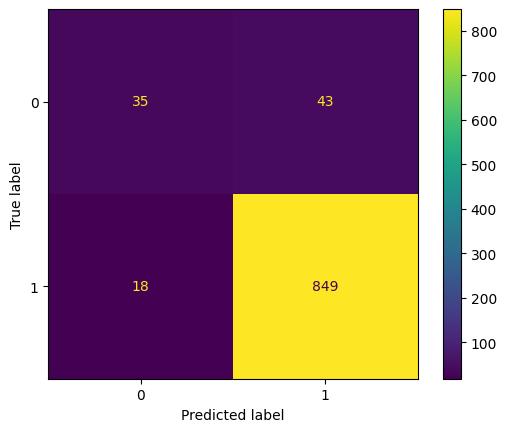

In [172]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [173]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open(r'C:\Users\Admin\Desktop\Programing\Projects\Sentiment Analysis\alexa-sentiment-analysis\model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [174]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [175]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9206349206349206


In [176]:
y_preds = model_dt.predict(X_test)

In [177]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 42  36]
 [ 89 778]]


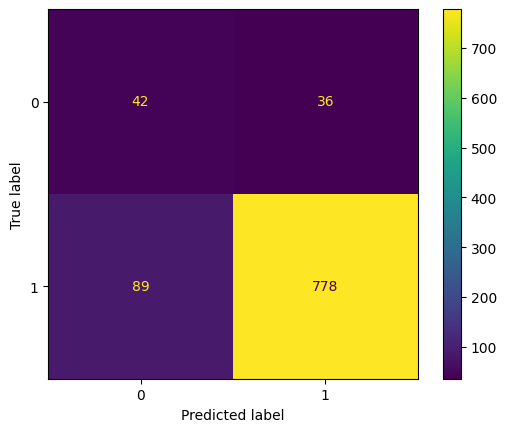

In [178]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()